In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libs

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data

In [ ]:

df = pd.read_csv('/kaggle/input/no-index-news/preprocessed_data (2).csv')

In [ ]:
df

In [ ]:
maxlen = df['Paragraph'].apply(lambda x: len(x.split())).max()

In [ ]:
maxlen

In [ ]:
df['len_words'] = df['Paragraph'].apply(lambda x: len(x.split()))

In [ ]:
# Biểu đồ phân phối độ dài theo số từ
plt.subplot(1, 2, 2)
sns.histplot(df['len_words'], bins=30, kde=True, color='salmon')
plt.title('Phân phối độ dài của Paragraph (theo số từ)')
plt.xlabel('Số từ')
plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()

In [ ]:
print(df.Topic.value_counts().sort_index())
fig, ax=plt.subplots(figsize=(8,5))
sns.barplot(x=df.Topic.value_counts().index, y=df.Topic.value_counts(), ax=ax)
ax.set_title("Distribution of Labels")
plt.show()

# Train Test Split

In [ ]:
# Chia train và temp (validation + test) với stratify
X_train, X_temp, y_train, y_temp = train_test_split(
    df['Paragraph'],
    df['Topic'],
    test_size=0.2,
    random_state=42,
    stratify=df['Topic']  # Phân phối đều theo nhãn Topic
)

# Chia tiếp temp thành validation và test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp  # Phân phối đều theo nhãn Topic
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

In [ ]:
print("Train distribution:")
print(y_train.value_counts(normalize=True))  # Tỷ lệ mỗi class trong tập train

print("\nValidation distribution:")
print(y_val.value_counts(normalize=True))  # Tỷ lệ mỗi class trong tập validation

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))  # Tỷ lệ mỗi class trong tập test

# Embedding Paragraphs

In [ ]:
def extract_cls_embeddings_from_paragraphs(paragraphs, tokenizer, model, device, max_length=128):
    """
    Trích xuất embeddings của token [CLS] từ danh sách các đoạn văn
    Args:
        paragraphs (list of str): Danh sách các đoạn văn đã được tokenize sẵn
        tokenizer: PhoBERT tokenizer
        model: PhoBERT model
        max_length (int): Độ dài tối đa của các đoạn văn
    Returns:
        list of torch.Tensor: Danh sách embeddings của token [CLS] (kích thước 768 cho mỗi đoạn văn)
    """
    embeddings_list = []

    for text in tqdm(paragraphs, desc="Trích xuất embeddings [CLS]"):
        # Tokenize đoạn văn
        inputs = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors="pt"
        )

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        # Trích xuất embeddings từ PhoBERT
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask)

        # Lấy embeddings của token [CLS]
        cls_embedding = output['last_hidden_state'][:, 0, :]  # (batch_size=1, 768)

        embeddings_list.append(cls_embedding.squeeze(0))  # Xóa batch dim (1, 768) -> (768,)

    return embeddings_list

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

## PhoBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base").to(device)

## Embeddings

In [ ]:
print("\nTrích xuất embeddings cho tập train...")
train_embeddings = extract_cls_embeddings_from_paragraphs(X_train.values, tokenizer, model, device)

print("\nTrích xuất embeddings cho tập validation...")
val_embeddings = extract_cls_embeddings_from_paragraphs(X_val.values, tokenizer, model, device)

print("\nTrích xuất embeddings cho tập test...")
test_embeddings = extract_cls_embeddings_from_paragraphs(X_test.values, tokenizer, model, device)

In [ ]:
# Hàm lưu embeddings và labels thành file .pt (PyTorch file)
def save_embeddings_to_file(embeddings, labels, filename):
    """
    Lưu embeddings và labels vào file .pt (dùng torch.save)
    Args:
        embeddings (list of torch.Tensor): Danh sách embeddings của đoạn văn (kích thước 768)
        labels (list of int): Danh sách nhãn của đoạn văn
        filename (str): Đường dẫn file để lưu
    """
    torch.save({
        'embeddings': torch.stack(embeddings),  # Chuyển danh sách thành tensor
        'labels': torch.tensor(labels)
    }, filename)
    print(f"Đã lưu embeddings và labels vào file {filename}")

In [ ]:
# Lưu embeddings và nhãn thành file .pt
save_embeddings_to_file(train_embeddings, y_train.values, 'train_embeddings.pt')
save_embeddings_to_file(val_embeddings, y_val.values, 'val_embeddings.pt')
save_embeddings_to_file(test_embeddings, y_test.values, 'test_embeddings.pt')

# Dataset and DataLoader

In [ ]:
# Dataset để load embeddings và nhãn
class NewsDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Dataset nhận embeddings và labels làm đầu vào
        Args:
            embeddings (list of torch.Tensor): Danh sách embeddings của đoạn văn (kích thước 768)
            labels (list of int): Danh sách nhãn của đoạn văn
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [ ]:
train_dataset = NewsDataset(train_embeddings, y_train.values)
val_dataset = NewsDataset(val_embeddings, y_val.values)
test_dataset = NewsDataset(test_embeddings, y_test.values)

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Kiểm tra DataLoader
print("\nKiểm tra DataLoader...")
for embeddings, labels in train_loader:
  print("Kích thước embeddings:", embeddings.shape)  # (batch_size, 768)
  print("Kích thước labels:", labels.shape)  # (batch_size,)
  break

# MLP Model

In [120]:


class MLP(nn.Module):
    def __init__(self, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, input_dim=768, output_dim=15, dropout_rate=0.5):
        """
        Mô hình MLP cải tiến với Dropout, Batch Normalization, và LeakyReLU
        Args:
            input_dim (int): Kích thước đầu vào (embeddings từ PhoBERT)
            hidden_dim1 (int): Số neurons của lớp ẩn thứ nhất
            hidden_dim2 (int): Số neurons của lớp ẩn thứ hai
            hidden_dim3 (int): Số neurons của lớp ẩn thứ ba (nếu cần)
            output_dim (int): Số lớp đầu ra (số nhãn cần phân loại)
            dropout_rate (float): Tỷ lệ dropout
        """
        super(MLP, self).__init__()
        self.hidden_dim1=hidden_dim1
        self.hidden_dim2=hidden_dim2
        self.hidden_dim3=hidden_dim3
        self.hidden_dim4=hidden_dim4
        self.hidden_dim5=hidden_dim5
        
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.BatchNorm1d(hidden_dim3),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim3, hidden_dim4),
            nn.BatchNorm1d(hidden_dim4),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim4, hidden_dim5),
            nn.BatchNorm1d(hidden_dim5),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim5, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Train Loop

In [112]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    """
    Huấn luyện mô hình MLP
    Args:
        model (nn.Module): Mô hình MLP
        train_loader (DataLoader): Dataloader cho tập train
        val_loader (DataLoader): Dataloader cho tập validation
        criterion (nn.Module): Hàm mất mát (loss function)
        optimizer (torch.optim.Optimizer): Tối ưu hóa
        device (str): GPU hoặc CPU
        num_epochs (int): Số epoch huấn luyện
    """
    model.to(device)
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            
            # Backward pass và tối ưu hóa
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            
            # Tính accuracy cho tập train
            _, predicted = torch.max(outputs, 1)  # Lấy nhãn dự đoán
            correct += (predicted == labels).sum().item()  # So sánh nhãn dự đoán và nhãn thực
            total += labels.size(0)  # Tổng số mẫu
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total  # Tính tỷ lệ chính xác
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)

        # Đánh giá trên tập validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Tính accuracy cho tập validation
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, \nVal Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    return train_loss_history, val_loss_history

# Tuning HyperParameters

In [121]:
import itertools
import copy
import torch.nn as nn
import torch.optim as optim

# Hàm để train và evaluate một tổ hợp hyperparameters
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    model.to(device)
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Evaluate trên tập validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        
        # Lưu best loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss, val_accuracy

# Grid Search với các Optimizer: Adam, AdamW
def grid_search_with_optimizers(train_loader, val_loader, device):
    # Các giá trị hyperparameters
    learning_rates = [0.001, 0.0005]
    dropout_rates = [0.3, 0.5]
    hidden_dim1 = [512]
    hidden_dim2 = [256]
    hidden_dim3 = [128]
    hidden_dim4 = [64]  
    hidden_dim5 = [32]
    optimizers = ['Adam', 'AdamW']  # Các optimizer cần thử
    criterion = nn.CrossEntropyLoss()  # Chỉ dùng CrossEntropyLoss

    # Tạo tất cả các tổ hợp hyperparameters
    param_grid = itertools.product(learning_rates, dropout_rates, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, optimizers)

    best_params = None
    best_val_accuracy = 0
    best_model_state = None

    for lr, dropout, h1, h2, h3, h4, h5, opt_name in param_grid:
        print(f"Đang thử nghiệm với: lr={lr}, dropout={dropout}, h1={h1}, h2={h2}, h3={h3}, h4={h4}, h5={h5} optimizer={opt_name}")
        
        # Khởi tạo mô hình
        model = MLP(input_dim=768, hidden_dim1=h1, hidden_dim2=h2, hidden_dim3=h3, hidden_dim4=h4, hidden_dim5=h5, output_dim=15, dropout_rate=dropout)

        # Khởi tạo optimizer
        if opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr)

        # Scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-6)

        # Train và đánh giá
        val_loss, val_accuracy = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=40)
        print(f"Val Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}")

        # Lưu lại mô hình tốt nhất
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = (lr, dropout, h1, h2, h3, h4, h5, opt_name)
            best_model_state = copy.deepcopy(model.state_dict())

    print(f"\nBest Val Accuracy: {best_val_accuracy:.2f}% với hyperparameters:")
    print(f"lr={best_params[0]}, dropout={best_params[1]}, h1={best_params[2]}, h2={best_params[3]}, h3={best_params[4]}, h4={best_params[5]}, h5={best_params[6]} optimizer={best_params[7]}")
    return best_model_state, best_params

# Chạy Grid Search
best_model_state, best_params = grid_search_with_optimizers(train_loader, val_loader, device)

# Khởi tạo lại mô hình tốt nhất
best_model = MLP(input_dim=768, hidden_dim1=best_params[2], hidden_dim2=best_params[3], hidden_dim3=best_params[4], hidden_dim4=best_params[5], hidden_dim5=best_params[6],
                 output_dim=15, dropout_rate=best_params[1])
best_model.load_state_dict(best_model_state)


Đang thử nghiệm với: lr=0.001, dropout=0.3, h1=512, h2=256, h3=128, h4=64, h5=32 optimizer=Adam
Val Accuracy: 85.00%, Val Loss: 0.6667
Đang thử nghiệm với: lr=0.001, dropout=0.3, h1=512, h2=256, h3=128, h4=64, h5=32 optimizer=AdamW
Val Accuracy: 85.17%, Val Loss: 0.6638
Đang thử nghiệm với: lr=0.001, dropout=0.5, h1=512, h2=256, h3=128, h4=64, h5=32 optimizer=Adam
Val Accuracy: 83.53%, Val Loss: 0.6960
Đang thử nghiệm với: lr=0.001, dropout=0.5, h1=512, h2=256, h3=128, h4=64, h5=32 optimizer=AdamW
Val Accuracy: 83.43%, Val Loss: 0.7019
Đang thử nghiệm với: lr=0.0005, dropout=0.3, h1=512, h2=256, h3=128, h4=64, h5=32 optimizer=Adam
Val Accuracy: 85.03%, Val Loss: 0.6286
Đang thử nghiệm với: lr=0.0005, dropout=0.3, h1=512, h2=256, h3=128, h4=64, h5=32 optimizer=AdamW
Val Accuracy: 85.17%, Val Loss: 0.6290
Đang thử nghiệm với: lr=0.0005, dropout=0.5, h1=512, h2=256, h3=128, h4=64, h5=32 optimizer=Adam
Val Accuracy: 82.60%, Val Loss: 0.7119
Đang thử nghiệm với: lr=0.0005, dropout=0.5, h1=5

<All keys matched successfully>

# Training

In [123]:
model = MLP(input_dim=768, hidden_dim1=512, hidden_dim2=256, hidden_dim3=128,
            hidden_dim4=64, hidden_dim5=32, output_dim=15,dropout_rate= 0.3)

In [124]:
 # Khởi tạo hàm mất mát (CrossEntropy) và optimizer (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-6)

In [125]:
train_loss_history, val_loss_history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=40
    )

Epoch [1/40], Train Loss: 2.3871, Train Accuracy: 26.30%, 
Val Loss: 1.7512, Val Accuracy: 61.30%
Epoch [2/40], Train Loss: 1.7841, Train Accuracy: 54.83%, 
Val Loss: 1.3268, Val Accuracy: 70.50%
Epoch [3/40], Train Loss: 1.4223, Train Accuracy: 65.08%, 
Val Loss: 1.0812, Val Accuracy: 74.40%
Epoch [4/40], Train Loss: 1.1904, Train Accuracy: 70.90%, 
Val Loss: 0.9059, Val Accuracy: 77.87%
Epoch [5/40], Train Loss: 1.0268, Train Accuracy: 75.02%, 
Val Loss: 0.7964, Val Accuracy: 79.97%
Epoch [6/40], Train Loss: 0.9277, Train Accuracy: 77.00%, 
Val Loss: 0.7597, Val Accuracy: 79.67%
Epoch [7/40], Train Loss: 0.8405, Train Accuracy: 79.16%, 
Val Loss: 0.7413, Val Accuracy: 80.40%
Epoch [8/40], Train Loss: 0.7699, Train Accuracy: 80.83%, 
Val Loss: 0.7115, Val Accuracy: 80.63%
Epoch [9/40], Train Loss: 0.7319, Train Accuracy: 81.77%, 
Val Loss: 0.6892, Val Accuracy: 81.73%
Epoch [10/40], Train Loss: 0.6953, Train Accuracy: 82.39%, 
Val Loss: 0.6676, Val Accuracy: 82.70%
Epoch [11/40], Trai

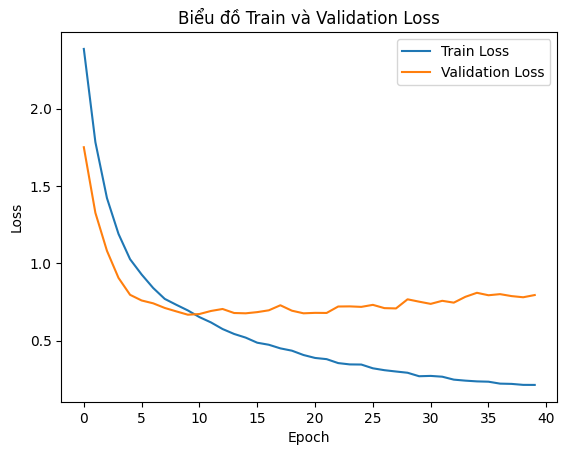

In [126]:
# Vẽ biểu đồ loss
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Biểu đồ Train và Validation Loss')
plt.show()

# Evaluate

In [127]:
def evaluate_model(model, test_loader, device):
    """
    Đánh giá mô hình trên tập test
    Args:
        model (nn.Module): Mô hình MLP
        test_loader (DataLoader): Dataloader cho tập test
        device (str): GPU hoặc CPU
    """
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_accuracy = 100 * correct / total
    print(f"Accuracy on Test set: {test_accuracy:.2f}%")
    return test_accuracy

In [128]:
print("\nĐánh giá mô hình trên tập test...")
test_accuracy = evaluate_model(model, test_loader, device)


Đánh giá mô hình trên tập test...
Accuracy on Test set: 84.10%


In [129]:
def evaluate_and_add_predictions(model, test_loader, df_test, device):
    """
    Đánh giá mô hình trên tập test và thêm cột "predict" vào DataFrame
    Args:
        model (nn.Module): Mô hình MLP
        test_loader (DataLoader): DataLoader cho tập test
        df_test (DataFrame): DataFrame chứa thông tin của tập test (cột Topic)
        device (str): GPU hoặc CPU
    Returns:
        DataFrame: DataFrame có thêm cột "predict" (nhãn dự đoán)
    """
    model.to(device)
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings = embeddings.to(device)
            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)  # Lấy nhãn dự đoán
            all_preds.extend(predicted.cpu().numpy())  # Chuyển kết quả về CPU và lưu vào all_preds
    
    # Thêm cột predict vào DataFrame
    df_test['predict'] = all_preds  # Thêm cột nhãn dự đoán
    df_test['correct'] = (df_test['predict'] == df_test['Topic'])  # Thêm cột đánh dấu đúng/sai
    print(f"\n Đã thêm cột 'predict' và 'correct' vào DataFrame.")
    
    # Hiển thị các mẫu mà mô hình phân loại sai
    df_errors = df_test[df_test['correct'] == False]  # Lọc các mẫu sai
    print(f" Số mẫu phân loại sai: {len(df_errors)} trên tổng số {len(df_test)} mẫu.")
    
    print("\n Ví dụ các mẫu phân loại sai:")
    print(df_errors[['Paragraph', 'Topic', 'predict']])  # Hiển thị 10 mẫu sai đầu tiên
    
    return df_test

In [130]:
df_test = pd.DataFrame({'Paragraph': X_test, 'Topic': y_test})

In [131]:
 df_test = evaluate_and_add_predictions(model, test_loader, df_test, device)


 Đã thêm cột 'predict' và 'correct' vào DataFrame.
 Số mẫu phân loại sai: 477 trên tổng số 3000 mẫu.

 Ví dụ các mẫu phân loại sai:
                                               Paragraph  Topic  predict
1638   ba bồn in tên logo của một công_ty sản_xuất co...      0       11
6597   theo ông hải quy_định mới có_thể gây áp_lực ba...      3        2
17057  một mô_hình đã gặp chút trục_trặc nhưng chúng_...      8        6
29849      tôi nhàn tênh vì con học như_chơi suốt năm mỹ     14        8
14151  chủ_tịch vạn_thịnh phát phân_trần suốt bao_nhi...      7        2
...                                                  ...    ...      ...
4560   các trung_tâm dữ_liệu đóng vai_trò quan_trọng ...      2       12
6537   với tham_vọng thúc_đẩy việt_nam trở_thành trun...      3        2
17333  số này được trường huy_động bằng nguồn xã_hội_...      8        5
6581   ubnd tỉnh bắc_giang vừa ban_hành bảng giá đất ...      3        0
24242  tuy_nhiên chính_phủ indonesia từ_chối cho rằng...     12 

In [132]:
df_test

,Paragraph,Topic,predict,correct
8821,hố này trải rộng triệu km và cách ấn độ km về ...,4,4,True
12951,bàn thắng của mbappe khiến tôi nhẹ_nhõm ông ch...,6,6,True
10970,timothée chalamet sinh năm sinh tại new york t...,5,5,True
24727,theo dự_thảo về luật sửa_đổi an_toàn trực_tuyế...,12,12,True
24303,ông phan trần thành phó_giám_đốc ngành_hàng ap...,12,12,True
...,...,...,...,...
10865,ca_sĩ hoàng hải trái và vũ_thảo_my cùng diện s...,5,5,True
10358,ca_sĩ erik là một trong số sao theo_đuổi mốt n...,5,5,True
25581,theo fpt nhờ tính_năng ai conversation người d...,12,12,True
28471,điều tôi thấy là vấn_đề giao_thông ùn_tắc khôn...,14,14,True


In [133]:
df_errors = df_test[df_test['correct'] == False]

In [134]:
error_counts = df_errors['Topic'].value_counts()

In [135]:
error_df = error_counts.reset_index()
error_df.columns = ['Topic', 'Error Count']
print(error_df)

    Topic  Error Count
0      10           75
1       0           40
2       4           38
3       7           34
4      12           33
5       2           33
6      14           33
7      13           30
8      11           30
9       3           29
10      8           27
11      5           22
12      9           21
13      1           21
14      6           11


In [136]:
class_names = ['Thời sự', 'Thế giới', 'Kinh doanh', 'Bất động sản', 
               'Khoa học', 'Giải trí', 'Thể thao', 'Pháp luật', 
               'Giáo dục', 'Sức khỏe', 'Đời sống', 'Du lịch', 
               'Số hóa', 'Ôtô - Xe máy', 'Ý kiến']

In [137]:


# Thêm cột "class" bằng cách ánh xạ Topic thành tên class tương ứng
error_df['Class'] = error_df['Topic'].apply(lambda x: class_names[x])

In [138]:
error_df

,Topic,Error Count,Class
0,10,75,Đời sống
1,0,40,Thời sự
2,4,38,Khoa học
3,7,34,Pháp luật
4,12,33,Số hóa
5,2,33,Kinh doanh
6,14,33,Ý kiến
7,13,30,Ôtô - Xe máy
8,11,30,Du lịch
9,3,29,Bất động sản
